#### **Feature_Engineer (Feature Transformation, Scaling, and Selection)**
#### Project name: **Telecom Customer Churn Prediction**
#### Author: **Fausto Pucheta Fortin**

### **Overview:** 
This notebook is the continuation of EDA_02. \
With the findings of the previous notebook, we now have the foundation to perform usefull **feature engineer techniques** that will help the model to generalize properly. The tasks of this notebook will provide the basis for the next phase, which is *Modeling & Evaluation*.

### Steps performed:
1. Binning:
    1. 'Age' binning with tree categories: 'Young Adults', 'Middle-age Adults', and 'Seniors'.
2. New Binary Features:
    1. 'high_support_calls': it will take **1** for customers that made more than 4 support calls, and **0** otherwise.
    2. 'high_payment_delay': it will take **1** for customers with a payment delay higher than 20 weeks, and **0** otherwise.
    3. 'high_spender': it will take **1** for customers who spent a total > $450 and **0** otherwise.
    4. 'Gender': current feature will be transformed into binary (**0** for males and **1** for females).
    5. 'monthly_contract': it will take **1** for customers with a monthly contract and **0** otherwise.
    6. 'low_interaction_cust': it will take **1** for customers with a last interaction of 14 months and **0** otherwise.

3. Interaction Features:
    1. 'age_support_calls_interaction' will be created **multiplying** 'age' and 'support calls'.
    2. 'payment_delay_to_total_spent_ratio' will be created **dividing** 'payment delay' with 'total spent'.
4. Feature Scaling:
    1. **Normalization** with *min-max* scaling 'age_support_calls_interaction' using MinMaxScaler.
    2. **Standardization** with *z-score scaling* 'payment_delay_to_total_spent_ratio' using StandardScaler().
    
5. Data Visualization:
    1. Correlation heatmap

6. Remove Unnecessary Features

7. Save Final Data Frame

### Findings:
1. New feature 'age_category' resulted in almost the same correlation than the original continuous feature 'Age' (**18%** vs **19%** respectively).
2. New binary features 'high_support_calls', 'high_payment_delay', 'monthly_contract', and 'low_spender' proved to be better than their predecessors. Having respectively a correlation of **54%**, **41%**, **37%**, **47%**, **36%**, and **41%**.
3. The new interaction features 'age_support_calls_interaction' and 'payment_delay_to_total_spent_ratio' turned out to be good possible indicators of churn, having a correlation of **47%** and **36%** respectively.
4. The *normalized* version and *standardized* version of 'age_support_calls_interaction' and 'payment_delay_to_total_spent_ratio', respectively, has the same impact in correlation between features and target variable.

### Further steps:
 **Modeling & Evaluation (Modeling_&_Evaluation.ipynb)**

1. Data Splitting
2. Save Training and Test data
3. Modeling:
    1. Decision Tree Classifier
    2. Random Forest Regressor
    3. XGBoost
4. Evaluation:
    1. Accuracy Score
    2. Recall
    3. F1 Score
5. Feature Importance Analysis

In [1]:
import sys
sys.path.append('../src/functions')

# EDA functions
from plot_functions import *

# Analysis libraries
import numpy as np
import pandas as pd
import pickle

# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Data
df = pd.read_pickle("../data/processed/imputed_df.pkl")

1. Binning

1. 1. 'Age' binning with tree categories: 'Young Adults', 'Middle-age Adults', and 'Seniors'.

In [2]:
def age_binning(X, age_column):
    # Define the bins and labels for age categories
    bins = [0, 29, 49, float('inf')]
    labels = ['Young Adults', 'Middle-age Adults', 'Seniors']

    # Create a new column 'age_category' with the age categories
    X['age_category'] = pd.cut(X[age_column], bins=bins, labels=labels, right=False)
    
    # Map age categories to numerical values
    category_mapping = {'Young Adults': 1, 'Middle-age Adults': 2, 'Seniors': 3}
    X['age_category'] = X['age_category'].map(category_mapping)
    
    return df


df = age_binning(df, "Age")

# Display the first few rows of the DataFrame to verify the new column
df[['Age', 'age_category']]

,Age,age_category
0,30.0,2
1,65.0,3
2,55.0,3
3,58.0,3
4,23.0,1
...,...,...
64369,45.0,2
64370,37.0,2
64371,25.0,1
64372,50.0,3


2. New binary features

2. 1. 'high_support_calls': \
It will take **1** for customers that made more than 4 support calls, and **0** otherwise.

In [3]:
df['high_support_calls'] = np.where(df['Support Calls'] > 4, 1, 0)

In [4]:
df[['high_support_calls', 'Support Calls']].head(10)

,high_support_calls,Support Calls
0,1,5.0
1,1,10.0
2,1,6.0
3,1,7.0
4,1,5.0
5,1,9.0
6,0,3.0
7,0,4.0
8,1,7.0
9,0,2.0


2. 2. 'high_payment_delay': \
It will take **1** for customers with a payment delay higher than 20 weeks, and **0** otherwise.

In [5]:
df['high_payment_delay'] = np.where(df['Payment Delay'] > 20, 1, 0)
# df.drop('hihg_payment_delay', axis=1, inplace=True)

In [6]:
df[['high_payment_delay', 'Payment Delay']].head(10)

,high_payment_delay,Payment Delay
0,0,18.0
1,0,8.0
2,0,18.0
3,0,7.0
4,0,8.0
5,1,26.0
6,0,16.0
7,0,15.0
8,0,4.0
9,0,11.0


2. 3. 'high_spender': \
 it will take **1** for customers who spent a total > $450 and **0** otherwise.


In [7]:
df['low_spender'] = np.where(df['Total Spend'] > 450, 0, 1)

In [8]:
df[['Total Spend', 'low_spender']].head(10)

,Total Spend,low_spender
0,932.0,0
1,557.0,0
2,185.0,1
3,396.0,1
4,617.0,0
5,129.0,1
6,821.0,0
7,445.0,1
8,969.0,0
9,415.0,1


2. 4. 'Gender': \
Transforming current feature into binary (**0** for males and **1** for females).

In [9]:
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Female' else 0)

In [10]:
df.head(10)

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn,age_category,high_support_calls,high_payment_delay,low_spender
0,30.0,1,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0,2,1,0,0
1,65.0,1,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0,3,1,0,0
2,55.0,1,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0,3,1,0,1
3,58.0,0,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0,3,1,0,1
4,23.0,0,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0,1,1,0,0
5,51.0,0,33.0,25.0,9.0,26.0,Premium,Annual,129.0,8.0,1.0,3,1,1,1
6,58.0,1,49.0,12.0,3.0,16.0,Standard,Quarterly,821.0,24.0,1.0,3,0,0,0
7,55.0,1,37.0,8.0,4.0,15.0,Premium,Annual,445.0,30.0,1.0,3,0,0,1
8,39.0,0,12.0,5.0,7.0,4.0,Standard,Quarterly,969.0,13.0,1.0,2,1,0,0
9,64.0,1,3.0,25.0,2.0,11.0,Standard,Quarterly,415.0,29.0,1.0,3,0,0,1


2. 5. 'monthly_contract': \
It will take **1** for customers with a monthly contract and **0** otherwise.

In [11]:
df['monthly_contract'] = df['Contract Length'].apply(lambda x: 1 if x == 'Monthly' else 0)

In [12]:
df[['Contract Length', 'monthly_contract']].head(10)

,Contract Length,monthly_contract
0,Annual,0
1,Monthly,1
2,Quarterly,0
3,Monthly,1
4,Monthly,1
5,Annual,0
6,Quarterly,0
7,Annual,0
8,Quarterly,0
9,Quarterly,0


2. 6. 'low_interaction_cust': \
It will take **1** for customers with a last interaction of 14 months and **0** otherwise.

In [13]:
df['low_interaction_cust'] = df['Last Interaction'].apply(lambda x: 1 if x > 14 else 0 )

In [14]:
df[['Last Interaction', 'low_interaction_cust']].head(10)

,Last Interaction,low_interaction_cust
0,17.0,1
1,6.0,0
2,3.0,0
3,29.0,1
4,20.0,1
5,8.0,0
6,24.0,1
7,30.0,1
8,13.0,0
9,29.0,1


3. Interaction Features


3. 1. Creation of 'age_support_calls_interaction' by **multiplying** 'age' and 'support calls'.

In [15]:
df['age_support_calls_interaction'] = df['Age'] * df['Support Calls']

In [16]:
df[['Age', 'Support Calls', 'age_support_calls_interaction']].head(10)

,Age,Support Calls,age_support_calls_interaction
0,30.0,5.0,150.0
1,65.0,10.0,650.0
2,55.0,6.0,330.0
3,58.0,7.0,406.0
4,23.0,5.0,115.0
5,51.0,9.0,459.0
6,58.0,3.0,174.0
7,55.0,4.0,220.0
8,39.0,7.0,273.0
9,64.0,2.0,128.0



3. 2. Creation of 'payment_delay_to_total_spent_ratio' **dividing** 'payment delay' with 'total spent'.

In [17]:
df['payment_delay_to_total_spent_ratio'] = df['Payment Delay'] / df['Total Spend']

In [18]:
df[['Payment Delay', 'Total Spend', 'payment_delay_to_total_spent_ratio']].head(10)

,Payment Delay,Total Spend,payment_delay_to_total_spent_ratio
0,18.0,932.0,0.019313
1,8.0,557.0,0.014363
2,18.0,185.0,0.097297
3,7.0,396.0,0.017677
4,8.0,617.0,0.012966
5,26.0,129.0,0.201550
6,16.0,821.0,0.019488
7,15.0,445.0,0.033708
8,4.0,969.0,0.004128
9,11.0,415.0,0.026506


In [19]:
df.head(10)

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn,age_category,high_support_calls,high_payment_delay,low_spender,monthly_contract,low_interaction_cust,age_support_calls_interaction,payment_delay_to_total_spent_ratio
0,30.0,1,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0,2,1,0,0,0,1,150.0,0.019313
1,65.0,1,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0,3,1,0,0,1,0,650.0,0.014363
2,55.0,1,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0,3,1,0,1,0,0,330.0,0.097297
3,58.0,0,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0,3,1,0,1,1,1,406.0,0.017677
4,23.0,0,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0,1,1,0,0,1,1,115.0,0.012966
5,51.0,0,33.0,25.0,9.0,26.0,Premium,Annual,129.0,8.0,1.0,3,1,1,1,0,0,459.0,0.201550
6,58.0,1,49.0,12.0,3.0,16.0,Standard,Quarterly,821.0,24.0,1.0,3,0,0,0,0,1,174.0,0.019488
7,55.0,1,37.0,8.0,4.0,15.0,Premium,Annual,445.0,30.0,1.0,3,0,0,1,0,1,220.0,0.033708
8,39.0,0,12.0,5.0,7.0,4.0,Standard,Quarterly,969.0,13.0,1.0,2,1,0,0,0,0,273.0,0.004128
9,64.0,1,3.0,25.0,2.0,11.0,Standard,Quarterly,415.0,29.0,1.0,3,0,0,1,0,1,128.0,0.026506


In [20]:
df.describe()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn,high_support_calls,high_payment_delay,low_spender,monthly_contract,low_interaction_cust,age_support_calls_interaction,payment_delay_to_total_spent_ratio
count,505207.000000,505207.000000,505207.000000,505207.000000,505207.000000,505207.000000,505207.000000,505207.000000,505206.000000,505207.000000,505207.000000,505207.000000,505207.000000,505207.000000,505207.000000,505207.000000
mean,39.704173,0.445229,31.350437,15.714826,3.833316,13.496842,620.072823,14.610579,0.555203,0.362675,0.221115,0.253255,0.216216,0.478036,158.026825,0.030504
std,12.670564,0.496992,17.237464,8.619314,3.133600,8.451179,245.319016,8.608278,0.496944,0.480773,0.414998,0.434876,0.411664,0.499518,148.077611,0.035254
min,18.000000,0.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,0.000000,16.000000,8.000000,1.000000,6.000000,446.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.000000,0.009863
50%,40.000000,0.000000,32.000000,16.000000,3.000000,13.000000,648.900000,14.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,116.000000,0.020408
75%,49.000000,1.000000,46.000000,23.000000,6.000000,20.000000,824.000000,22.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,240.000000,0.035427
max,65.000000,1.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,650.000000,0.300000


5. Data Visualization

5. 1. Correlation heatmap

<module 'matplotlib.pyplot' from 'c:\\Users\\Fausto\\Telecom-Customer-Churn-Prediction\\churnvenv\\lib\\site-packages\\matplotlib\\pyplot.py'>

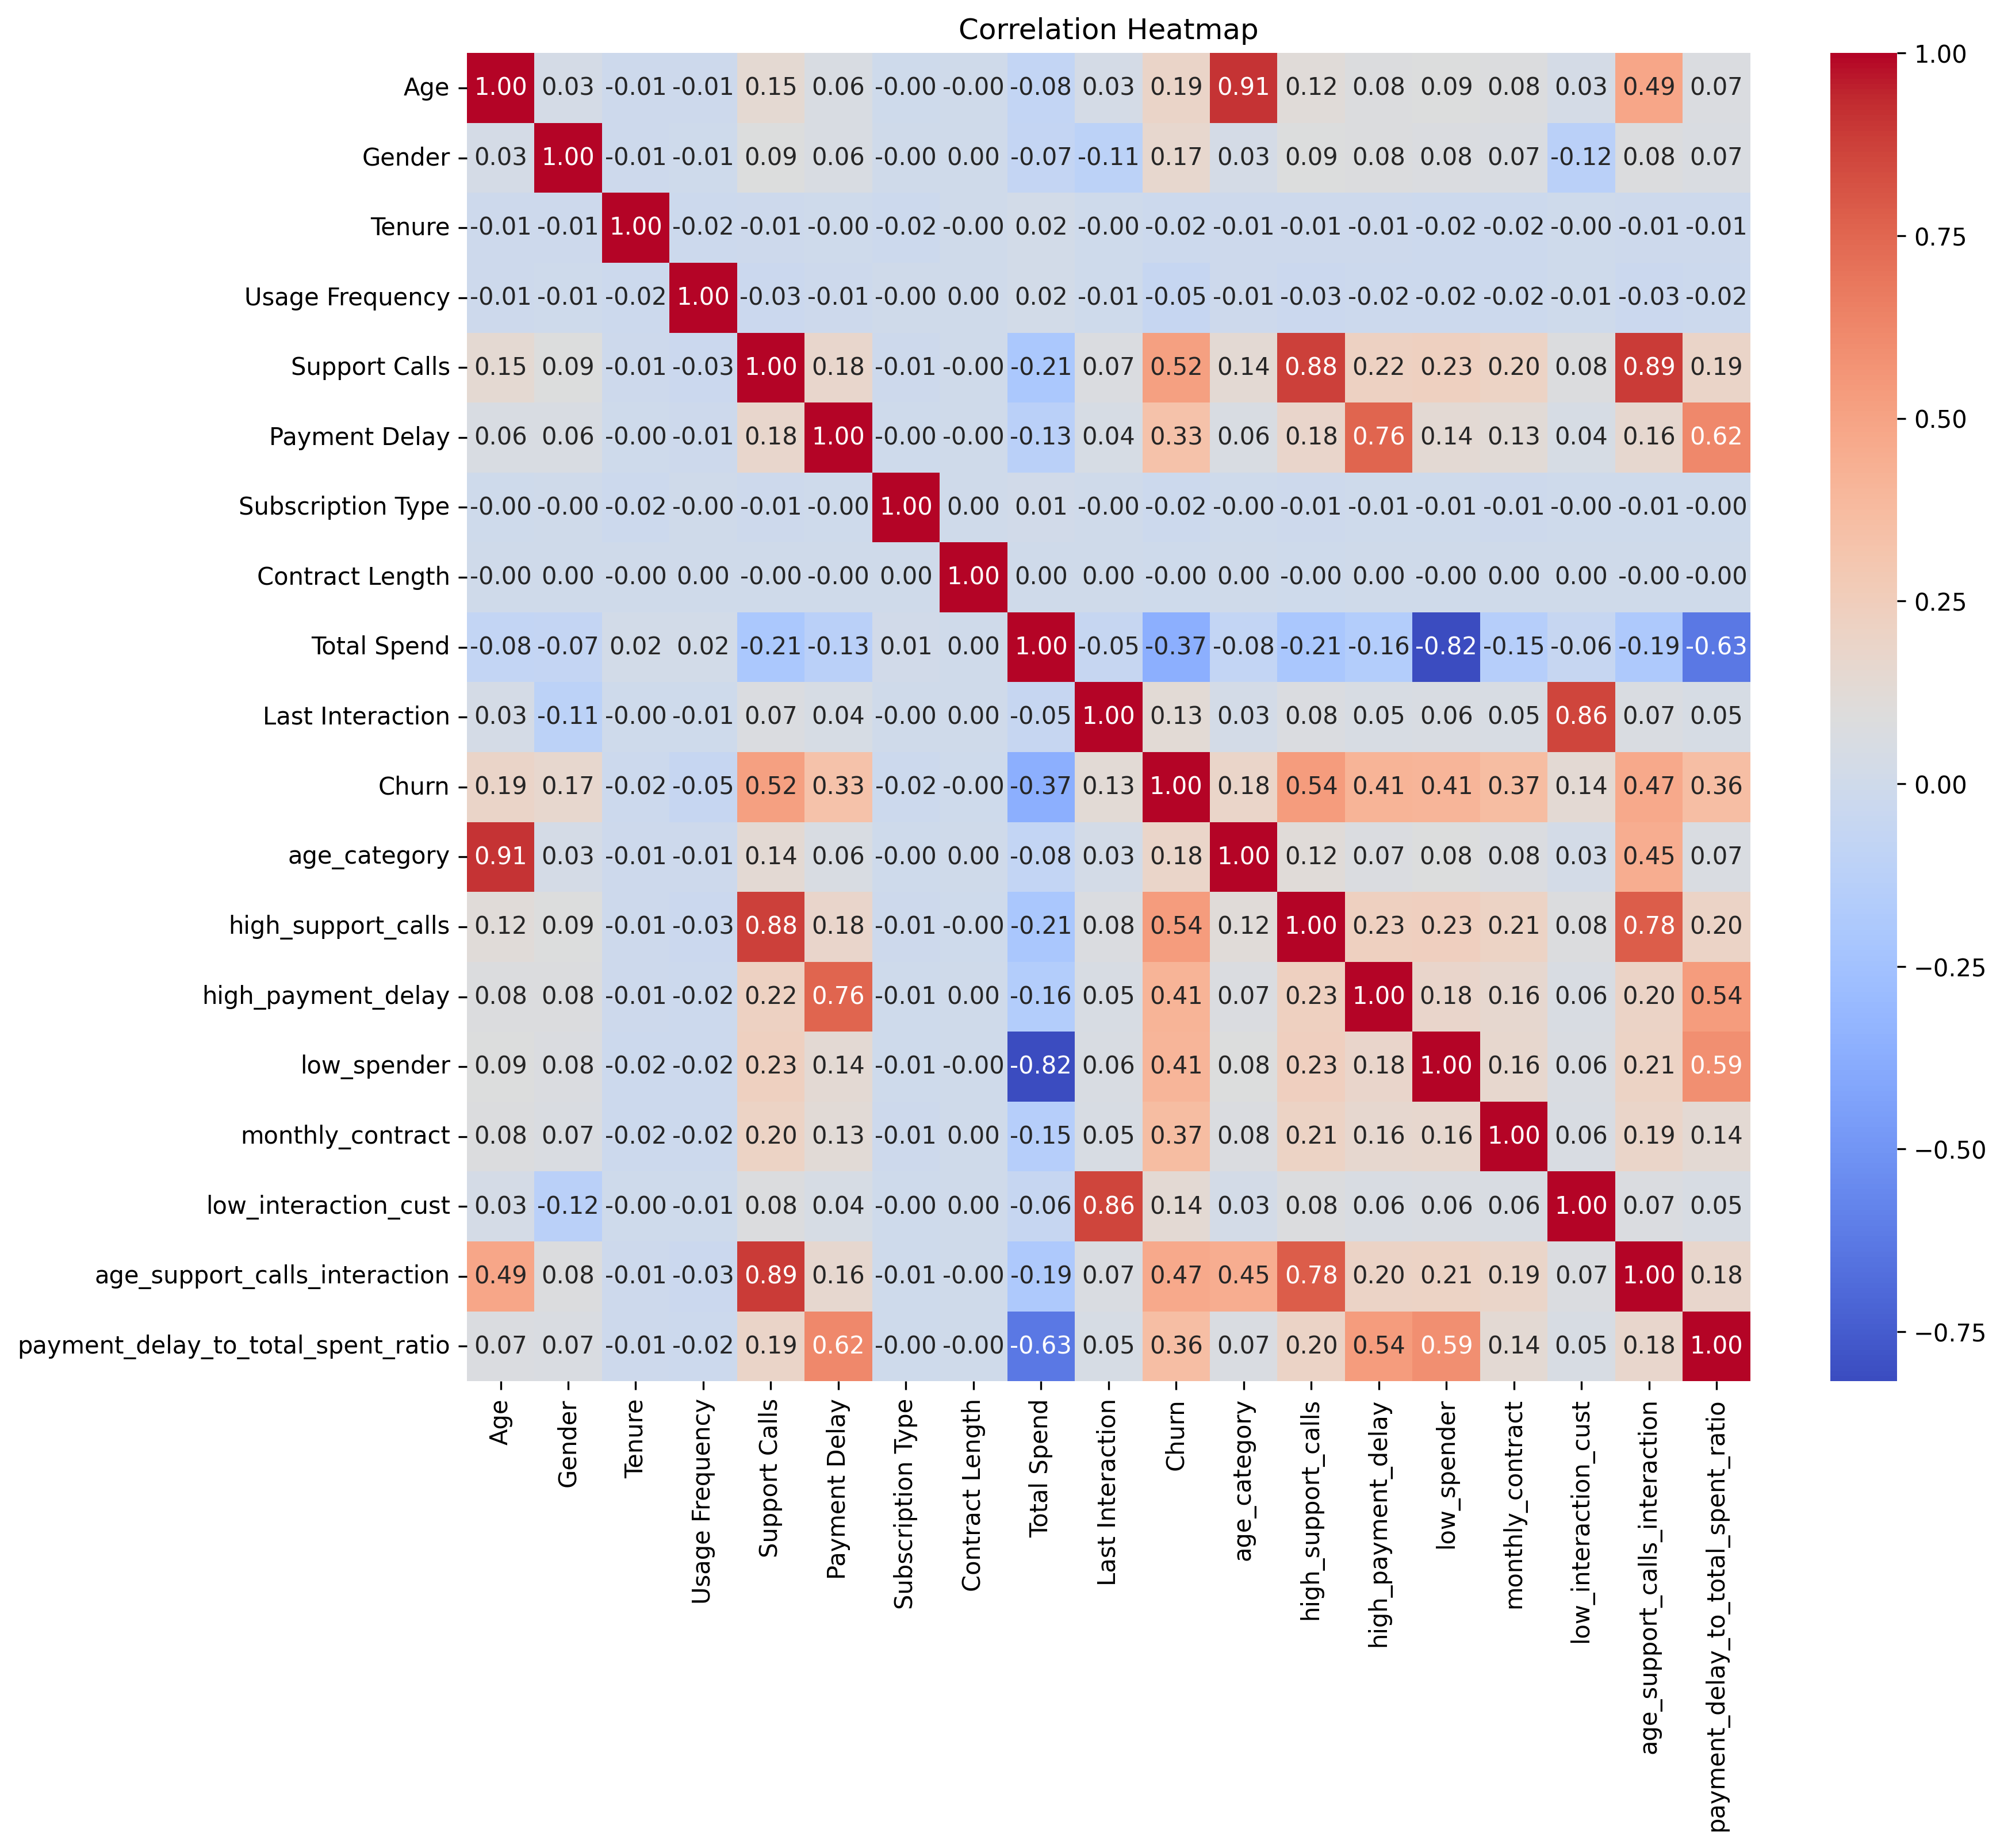

In [21]:
plot_correlation_heatmap(df)


6. Remove Unnecessary Features

In [22]:
df.columns

Index(['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls',
       'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend',
       'Last Interaction', 'Churn', 'age_category', 'high_support_calls',
       'high_payment_delay', 'low_spender', 'monthly_contract',
       'low_interaction_cust', 'age_support_calls_interaction',
       'payment_delay_to_total_spent_ratio'],
      dtype='object')

In [23]:
df.drop(columns=['Age','Tenure', 'Usage Frequency',
                 'Support Calls', 'Payment Delay',
                 'Subscription Type', 'Contract Length',
                 'Total Spend', 'Last Interaction'], inplace=True)

7. Save Final Data Frame

In [28]:
with open("../data/processed/modeling_df.pkl", "wb") as file:
    pickle.dump(df, file)